### Задание:

1. Подобрать оптимальный набор элементных признаков и алгоритм машинного обучения (тот, который будет давать минимальную ошибку) для базы данных сталей steels_kaggle.
2. Визуализировать датасет с помощью метода сокращения размерности. Сделать кластеризацию и отобразить различные кластеры. (не обязательно, если есть желание)


# задача 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



In [2]:
df = pd.read_csv('Steels_kaggle.csv')
df.columns = df.columns.str.strip()
print(f'Размер датасета: {df.shape}')
print(f'Кол-во уникальных сплавов: {df['Alloy code'].nunique()}')
df.head()

Размер датасета: (915, 20)
Кол-во уникальных сплавов: 95


,Alloy code,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Nb + Ta,Temperature (°C),0.2% Proof Stress (MPa),Tensile Strength (MPa),Elongation (%),Reduction in Area (%)
0,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,27,342,490,30,71
1,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,100,338,454,27,72
2,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,200,337,465,23,69
3,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,300,346,495,21,70
4,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,400,316,489,26,79


тк домашка по типу кагл соревнования я решил пообщаться с генеративкой чтобы она предложила возможно как то расширить признаки на основе взаимодействий, тк это не запрещено, я просто так сказать играюсь с тем что есть) я ему скинул датасет и спросил какие можно добавить признаки из тех что есть. идея такая возникла потому что я читал какой то телег канал про кагл соревнования и кто то так делал, но если что это отдельный датасети как бы если это запрещено то не снимайте пжаста, я на двух валидировать буду

In [3]:
def create_engineering_features(df):
    df_eng = df.copy()

    # сум основных легирующих элементов
    df_eng["total_alloying"] = (
        df_eng["C"]
        + df_eng["Si"]
        + df_eng["Mn"]
        + df_eng["Ni"]
        + df_eng["Cr"]
        + df_eng["Mo"]
    )

    # соотнш углерода к марганцу (важно для прочности слова гпт)
    df_eng["C_Mn_ratio"] = df_eng["C"] / (df_eng["Mn"] + 1e-6)

    # соотнш хрома к молибдену (влияет на коррозионную стойкость слова гпт)
    df_eng["Cr_Mo_ratio"] = df_eng["Cr"] / (df_eng["Mo"] + 1e-6)

    # эквиваоени углерода (важный параметр для свариваемости слова гпт)
    df_eng["carbon_equivalent"] = (
        df_eng["C"]
        + df_eng["Mn"] / 6
        + (df_eng["Cr"] + df_eng["Mo"] + df_eng["V"]) / 5
        + (df_eng["Ni"] + df_eng["Cu"]) / 15
    )

    # взаимод температуры с составом
    df_eng["temp_carbon_interaction"] = df_eng["Temperature (°C)"] * df_eng["C"]
    df_eng["temp_manganese_interaction"] = df_eng["Temperature (°C)"] * df_eng["Mn"]

    # квдрт члены для важных элементов
    df_eng["C_squared"] = df_eng["C"] ** 2
    df_eng["Mn_squared"] = df_eng["Mn"] ** 2
    df_eng["Cr_squared"] = df_eng["Cr"] ** 2

    # лог температуры (спасибо курсу МО1)
    df_eng["log_temperature"] = np.log(df_eng["Temperature (°C)"] + 1)

    return df_eng


df_engineered = create_engineering_features(df)
targets = [
    '0.2% Proof Stress (MPa)',
    'Tensile Strength (MPa)',
    'Elongation (%)',
    'Reduction in Area (%)',
]
categorical = ['Alloy code']
X = df.drop(columns=targets)
y = df[targets]
X_eng = df_engineered.drop(columns=targets)
NUMERIC_ENG = [c for c in X_eng.columns if c not in categorical]

так ну давайте попробуем обучить самые классик мо модели (без нейронок тк классик мо не про нейронки) и я возьму самые хорошие на оптимизиацию

In [4]:
def evaluate_models(X, y, models_dict, cv_folds=5):
    results = {}
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), [c for c in X.columns if c not in categorical]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ])
    X_processed = preprocessor.fit_transform(X)
    for name, model in models_dict.items():
            print(f'оценка модели: {name}')
            if name in ['Gradient Boosting', 'Random Forest']:
                model_wrapper = MultiOutputRegressor(model)
            else:
                model_wrapper = model
            scores = cross_val_score(model_wrapper, X_processed, y, cv=cv_folds, scoring='neg_mean_squared_error')
            rmse_scores = np.sqrt(-scores)
            results[name] = {
                'mean_rmse': rmse_scores.mean(),
                'scores': rmse_scores
            }
            print(f'авг RMSE: {rmse_scores.mean():.4f}')

    return results

base_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, loss_function='MultiRMSE', verbose=False, random_seed=42)
}
print('оценка базовых моделей на инженерных признаках:')
base_results_eng = evaluate_models(X_eng, y, base_models)

print("оценка базовых моделей на обычных признаках:")
base_results_eng = evaluate_models(X, y, base_models)

оценка базовых моделей на инженерных признаках:
оценка модели: Linear Regression
авг RMSE: 88.5906
оценка модели: Ridge Regression
авг RMSE: 88.1609
оценка модели: Lasso Regression


/Users/roman/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38854.00474670157, tolerance: 4956.14916010929
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/roman/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2898.1571199353784, tolerance: 1334.8757519125684
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/roman/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326045.3352005482, tolerance: 5019.236987978143
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/roman/miniconda3/

авг RMSE: 87.4908
оценка модели: Random Forest
авг RMSE: 79.1837
оценка модели: Gradient Boosting
авг RMSE: 78.7730
оценка модели: CatBoost
авг RMSE: 80.1914
оценка базовых моделей на обычных признаках:
оценка модели: Linear Regression
авг RMSE: 90.3308
оценка модели: Ridge Regression
авг RMSE: 89.9307
оценка модели: Lasso Regression
авг RMSE: 89.2740
оценка модели: Random Forest
авг RMSE: 76.1082
оценка модели: Gradient Boosting
авг RMSE: 78.2452
оценка модели: CatBoost
авг RMSE: 81.0244


видно что на датасете с докинутыми признакиами лучше + катбус/градбуст/рандом форест показали лучшие метрики поэтому я займусь выбиванием качества с этих моделей

In [5]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_eng, y, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), [c for c in X_eng.columns if c not in categorical]),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
])
X_train_new_processed = preprocessor.fit_transform(X_train_new)
X_test_new_processed = preprocessor.transform(X_test_new)

In [6]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_eng, y, test_size=0.2, random_state=42
)
preprocessor_class = ColumnTransformer(
    [
        ("num", StandardScaler(), [c for c in X.columns if c not in categorical]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ]
)
X_train_class_processed = preprocessor_class.fit_transform(X_train_class)
X_test_class_processed = preprocessor_class.transform(X_test_class)

рандом форест

In [7]:
rf_param_grid = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [5, 10, None],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__max_features': ['sqrt', 'log2', None]
}
rf_base = RandomForestRegressor(random_state=42)
rf_model = MultiOutputRegressor(rf_base)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train_new_processed, y_train_new)
rf_best = rf_grid_search.best_estimator_
y_pred_rf = rf_best.predict(X_test_new_processed)
mse_rf = mean_squared_error(y_test_new, y_pred_rf, multioutput='raw_values')
rmse_rf_new = np.sqrt(mse_rf)
r2_rf_new = r2_score(y_test_new, y_pred_rf, multioutput='raw_values')
print('Random Forest для инженерных признаков:')
print('Лучшие параметры:', rf_grid_search.best_params_)
print('Средний RMSE:', rmse_rf_new.mean())
print('Средний R2:', r2_rf_new.mean())

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Random Forest для инженерных признаков:
Лучшие параметры: {'estimator__max_depth': 10, 'estimator__max_features': None, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100}
Средний RMSE: 33.98483402849921
Средний R2: 0.7559072367347385


In [8]:
rf_param_grid = {
    "estimator__n_estimators": [100, 200],
    "estimator__max_depth": [5, 10, None],
    "estimator__min_samples_split": [2, 5],
    "estimator__min_samples_leaf": [1, 2],
    "estimator__max_features": ["sqrt", "log2", None],
}
rf_base = RandomForestRegressor(random_state=42)
rf_model = MultiOutputRegressor(rf_base)
rf_grid_search = GridSearchCV(
    rf_model,
    rf_param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)
rf_grid_search.fit(X_train_class_processed, y_train_class)
rf_best = rf_grid_search.best_estimator_
y_pred_rf = rf_best.predict(X_test_class_processed)
mse_rf = mean_squared_error(y_test_class, y_pred_rf, multioutput="raw_values")
rmse_rf_class = np.sqrt(mse_rf)
r2_rf_class = r2_score(y_test_class, y_pred_rf, multioutput="raw_values")
print("Random Forest для изначальных признаков:")
print("Лучшие параметры:", rf_grid_search.best_params_)
print("Средний RMSE:", rmse_rf_class.mean())
print("Средний R2:", r2_rf_class.mean())

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Random Forest для изначальных признаков:
Лучшие параметры: {'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100}
Средний RMSE: 33.95427052248172
Средний R2: 0.7512715623007924


gradient boosting

In [9]:
gb_param_grid = {
    'estimator__n_estimators': [100, 200],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_depth': [3, 5],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__subsample': [0.8, 1.0]
}
gb_base = GradientBoostingRegressor(random_state=42)
gb_model = MultiOutputRegressor(gb_base)
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gb_grid_search.fit(X_train_new_processed, y_train_new)
gb_best = gb_grid_search.best_estimator_
y_pred_gb = gb_best.predict(X_test_new_processed)
mse_gb = mean_squared_error(y_test_new, y_pred_gb, multioutput='raw_values')
rmse_gb_new = np.sqrt(mse_gb)
r2_gb_new = r2_score(y_test_new, y_pred_gb, multioutput='raw_values')
print('Gradient Boosting для инженерных признаков:')
print('Лучшие параметры:', gb_grid_search.best_params_)
print('Средний RMSE:', rmse_gb_new.mean())
print('Средний R2:', r2_gb_new.mean())

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Gradient Boosting для инженерных признаков:
Лучшие параметры: {'estimator__learning_rate': 0.05, 'estimator__max_depth': 3, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 200, 'estimator__subsample': 1.0}
Средний RMSE: 31.298695353160888
Средний R2: 0.7805630346395649


In [10]:
gb_param_grid = {
    "estimator__n_estimators": [100, 200],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__max_depth": [3, 5],
    "estimator__min_samples_split": [2, 5],
    "estimator__min_samples_leaf": [1, 2],
    "estimator__subsample": [0.8, 1.0],
}
gb_base = GradientBoostingRegressor(random_state=42)
gb_model = MultiOutputRegressor(gb_base)
gb_grid_search = GridSearchCV(
    gb_model,
    gb_param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)
gb_grid_search.fit(X_train_class_processed, y_train_class)
gb_best = gb_grid_search.best_estimator_
y_pred_gb = gb_best.predict(X_test_class_processed)
mse_gb = mean_squared_error(y_test_class, y_pred_gb, multioutput="raw_values")
rmse_gb_class = np.sqrt(mse_gb)
r2_gb_class = r2_score(y_test_class, y_pred_gb, multioutput="raw_values")
print("Gradient Boosting для изначальных признаков:")
print("Лучшие параметры:", gb_grid_search.best_params_)
print("Средний RMSE:", rmse_gb_class.mean())
print("Средний R2:", r2_gb_class.mean())

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Gradient Boosting для изначальных признаков:
Лучшие параметры: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 5, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100, 'estimator__subsample': 0.8}
Средний RMSE: 36.93019020479151
Средний R2: 0.6828207218766849


Catboost

In [ ]:
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    loss_function='MultiRMSE',
    eval_metric='MultiRMSE',
    verbose=100,
    random_seed=42
)
train_pool = Pool(X_train_new, y_train_new, cat_features=categorical)
test_pool = Pool(X_test_new, y_test_new, cat_features=categorical)
catboost_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)
y_pred_catboost = catboost_model.predict(X_test_new)
mse_catboost = mean_squared_error(y_test_new, y_pred_catboost, multioutput='raw_values')
rmse_catboost_new = np.sqrt(mse_catboost)
r2_catboost_new = r2_score(y_test_new, y_pred_catboost, multioutput='raw_values')
print("CatBoost для инженерных признаков:")
print("Средний RMSE:", rmse_catboost_new.mean())
print("Средний R2:", r2_catboost_new.mean())

In [12]:
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    loss_function="MultiRMSE",
    eval_metric="MultiRMSE",
    verbose=100,
    random_seed=42,
)
train_pool = Pool(X_train_class, y_train_class, cat_features=categorical)
test_pool = Pool(X_test_class, y_test_class, cat_features=categorical)
catboost_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)
y_pred_catboost = catboost_model.predict(X_test_class)
mse_catboost = mean_squared_error(
    y_test_class, y_pred_catboost, multioutput="raw_values"
)
rmse_catboost_class = np.sqrt(mse_catboost)
r2_catboost_class = r2_score(y_test_class, y_pred_catboost, multioutput="raw_values")
print("CatBoost для изначальных признаков:")
print("Средний RMSE:", rmse_catboost_class.mean())
print("Средний R2:", r2_catboost_class.mean())

0:	learn: 288.8386959	test: 167.4374553	best: 167.4374553 (0)	total: 4.24ms	remaining: 4.24s
100:	learn: 154.5145546	test: 64.2544687	best: 63.3931039 (96)	total: 364ms	remaining: 3.24s
200:	learn: 103.8801461	test: 54.6888301	best: 54.6888301 (200)	total: 725ms	remaining: 2.88s
300:	learn: 66.9735191	test: 50.5974544	best: 50.5974544 (300)	total: 1.14s	remaining: 2.65s
400:	learn: 43.2649101	test: 48.1315693	best: 48.1315693 (400)	total: 1.57s	remaining: 2.34s
500:	learn: 33.3758147	test: 46.8715932	best: 46.8540877 (496)	total: 1.95s	remaining: 1.94s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 46.39480836
bestIteration = 537

Shrink model to first 538 iterations.
CatBoost для изначальных признаков:
Средний RMSE: 18.20905585894178
Средний R2: 0.890940048269344


In [13]:
comparison = pd.DataFrame({
    'Модель': ['CatBoost', 'Random Forest', 'Gradient Boosting'],
    'Средний RMSE обычных признаков': [rmse_catboost_class.mean(), rmse_rf_class.mean(), rmse_gb_class.mean()],
    'Средний R2 обычных признаков': [r2_catboost_class.mean(), r2_rf_class.mean(), r2_gb_class.mean()],
    'Средний RMSE инженерных признаков': [rmse_catboost_new.mean(), rmse_rf_new.mean(), rmse_gb_new.mean()],
    'Средний R2 инженерных признаков': [r2_catboost_new.mean(), r2_rf_new.mean(), r2_gb_new.mean()]
})
comparison

,Модель,Средний RMSE обычных признаков,Средний R2 обычных признаков,Средний RMSE инженерных признаков,Средний R2 инженерных признаков
0,CatBoost,18.209056,0.890940,18.209056,0.890940
1,Random Forest,33.954271,0.751272,33.984834,0.755907
2,Gradient Boosting,36.930190,0.682821,31.298695,0.780563


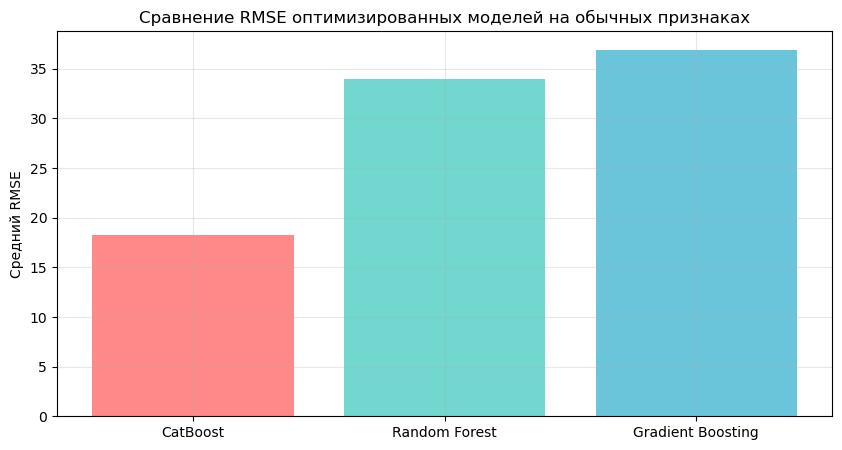

In [14]:
plt.figure(figsize=(10, 5))
plt.bar(
    comparison["Модель"],
    comparison["Средний RMSE обычных признаков"],
    color=["#FF6B6B", "#4ECDC4", "#45B7D1"],
    alpha=0.8,
)
plt.title("Сравнение RMSE оптимизированных моделей на обычных признаках")
plt.ylabel("Средний RMSE")
plt.grid(True, alpha=0.3)
plt.show()

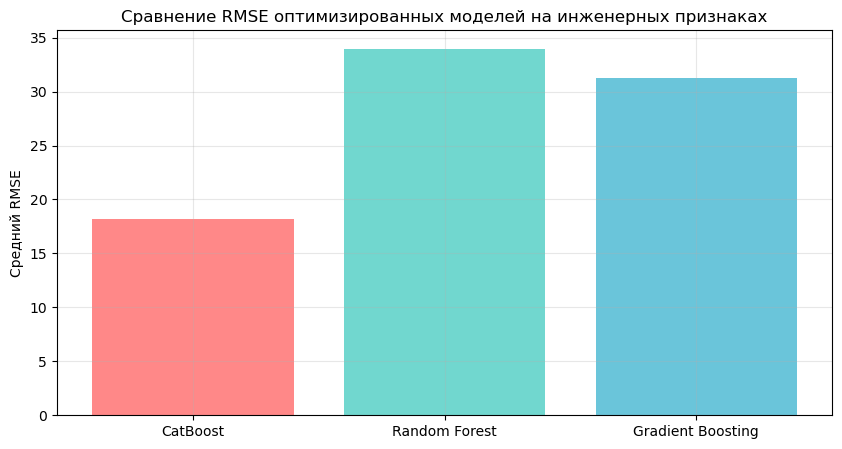

In [15]:
plt.figure(figsize=(10, 5))
plt.bar(
    comparison["Модель"],
    comparison["Средний RMSE инженерных признаков"],
    color=["#FF6B6B", "#4ECDC4", "#45B7D1"],
    alpha=0.8,
)
plt.title("Сравнение RMSE оптимизированных моделей на инженерных признаках")
plt.ylabel("Средний RMSE")
plt.grid(True, alpha=0.3)
plt.show()

видим что на самом деле только в случае катбуста есть какая то чуток (совсем) значимая разница данные с доп признаками или нет, идея себя не оправдала( но энивей среди всех лучшая модель катбус! поэтому буду дальше работать с ней и перейду к анализу важности признаков (использую модель оптимальную с датасетом изначальных признаков)

Топ важных признаков
                       feature  importance
10                           V   21.084612
0                   Alloy code   16.286810
25             log_temperature   14.930417
15            Temperature (°C)   11.393001
20     temp_carbon_interaction    7.322496
21  temp_manganese_interaction    5.978376
8                           Mo    2.950288
11                          Al    2.944916
16              total_alloying    1.830490
1                            C    1.755036
6                           Ni    1.569028
23                  Mn_squared    1.540438
3                           Mn    1.207513
19           carbon_equivalent    1.204397
17                  C_Mn_ratio    1.142044


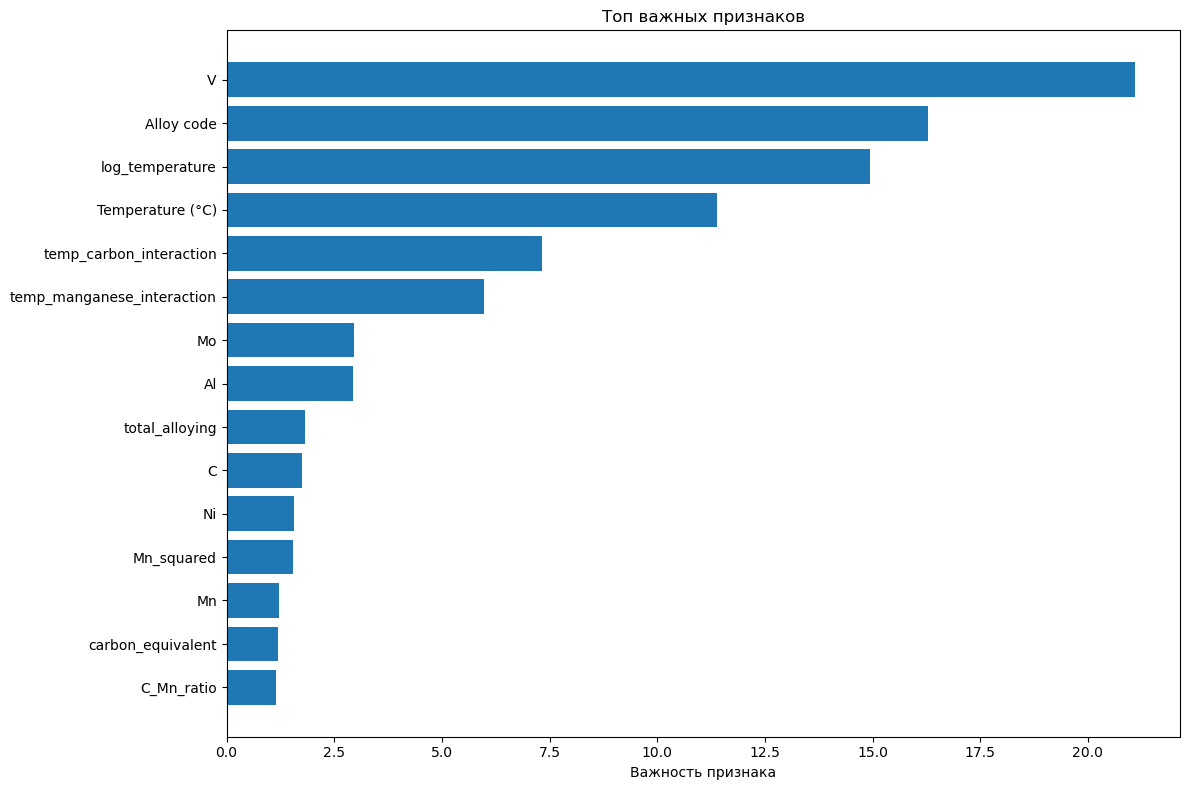

Оптимальный набор признаков (8): ['V', 'Alloy code', 'log_temperature', 'Temperature (°C)', 'temp_carbon_interaction', 'temp_manganese_interaction', 'Mo', 'Al']


In [16]:
feature_importance = catboost_model.get_feature_importance()
feature_names = X_eng.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
print("Топ важных признаков")
print(importance_df.head(15))
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Важность признака')
plt.title('Топ важных признаков')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
optimal_features = importance_df[importance_df['importance'] > importance_df['importance'].quantile(0.7)]['feature'].tolist()
print(f'Оптимальный набор признаков ({len(optimal_features)}): {optimal_features}')

таким образом лучшая rmse 0.18 была достигнута с оптимизированным катбустом и был найден оптимальный набор признаков (вот выше). конечно чтобы достичь таких резов я провел анализ взяв классик мо модели сравнил их, в целом я и ожидал что катбуст покажет топ резы, не зря ее все так любят. думаю что если бы мы не ограничивались мо моделями, а еще докинули нейронки то все равно не изменилось бы сильно ничего, для такой задачи классик мо хватит

# задача 2


Визуализация для обычных признаков:


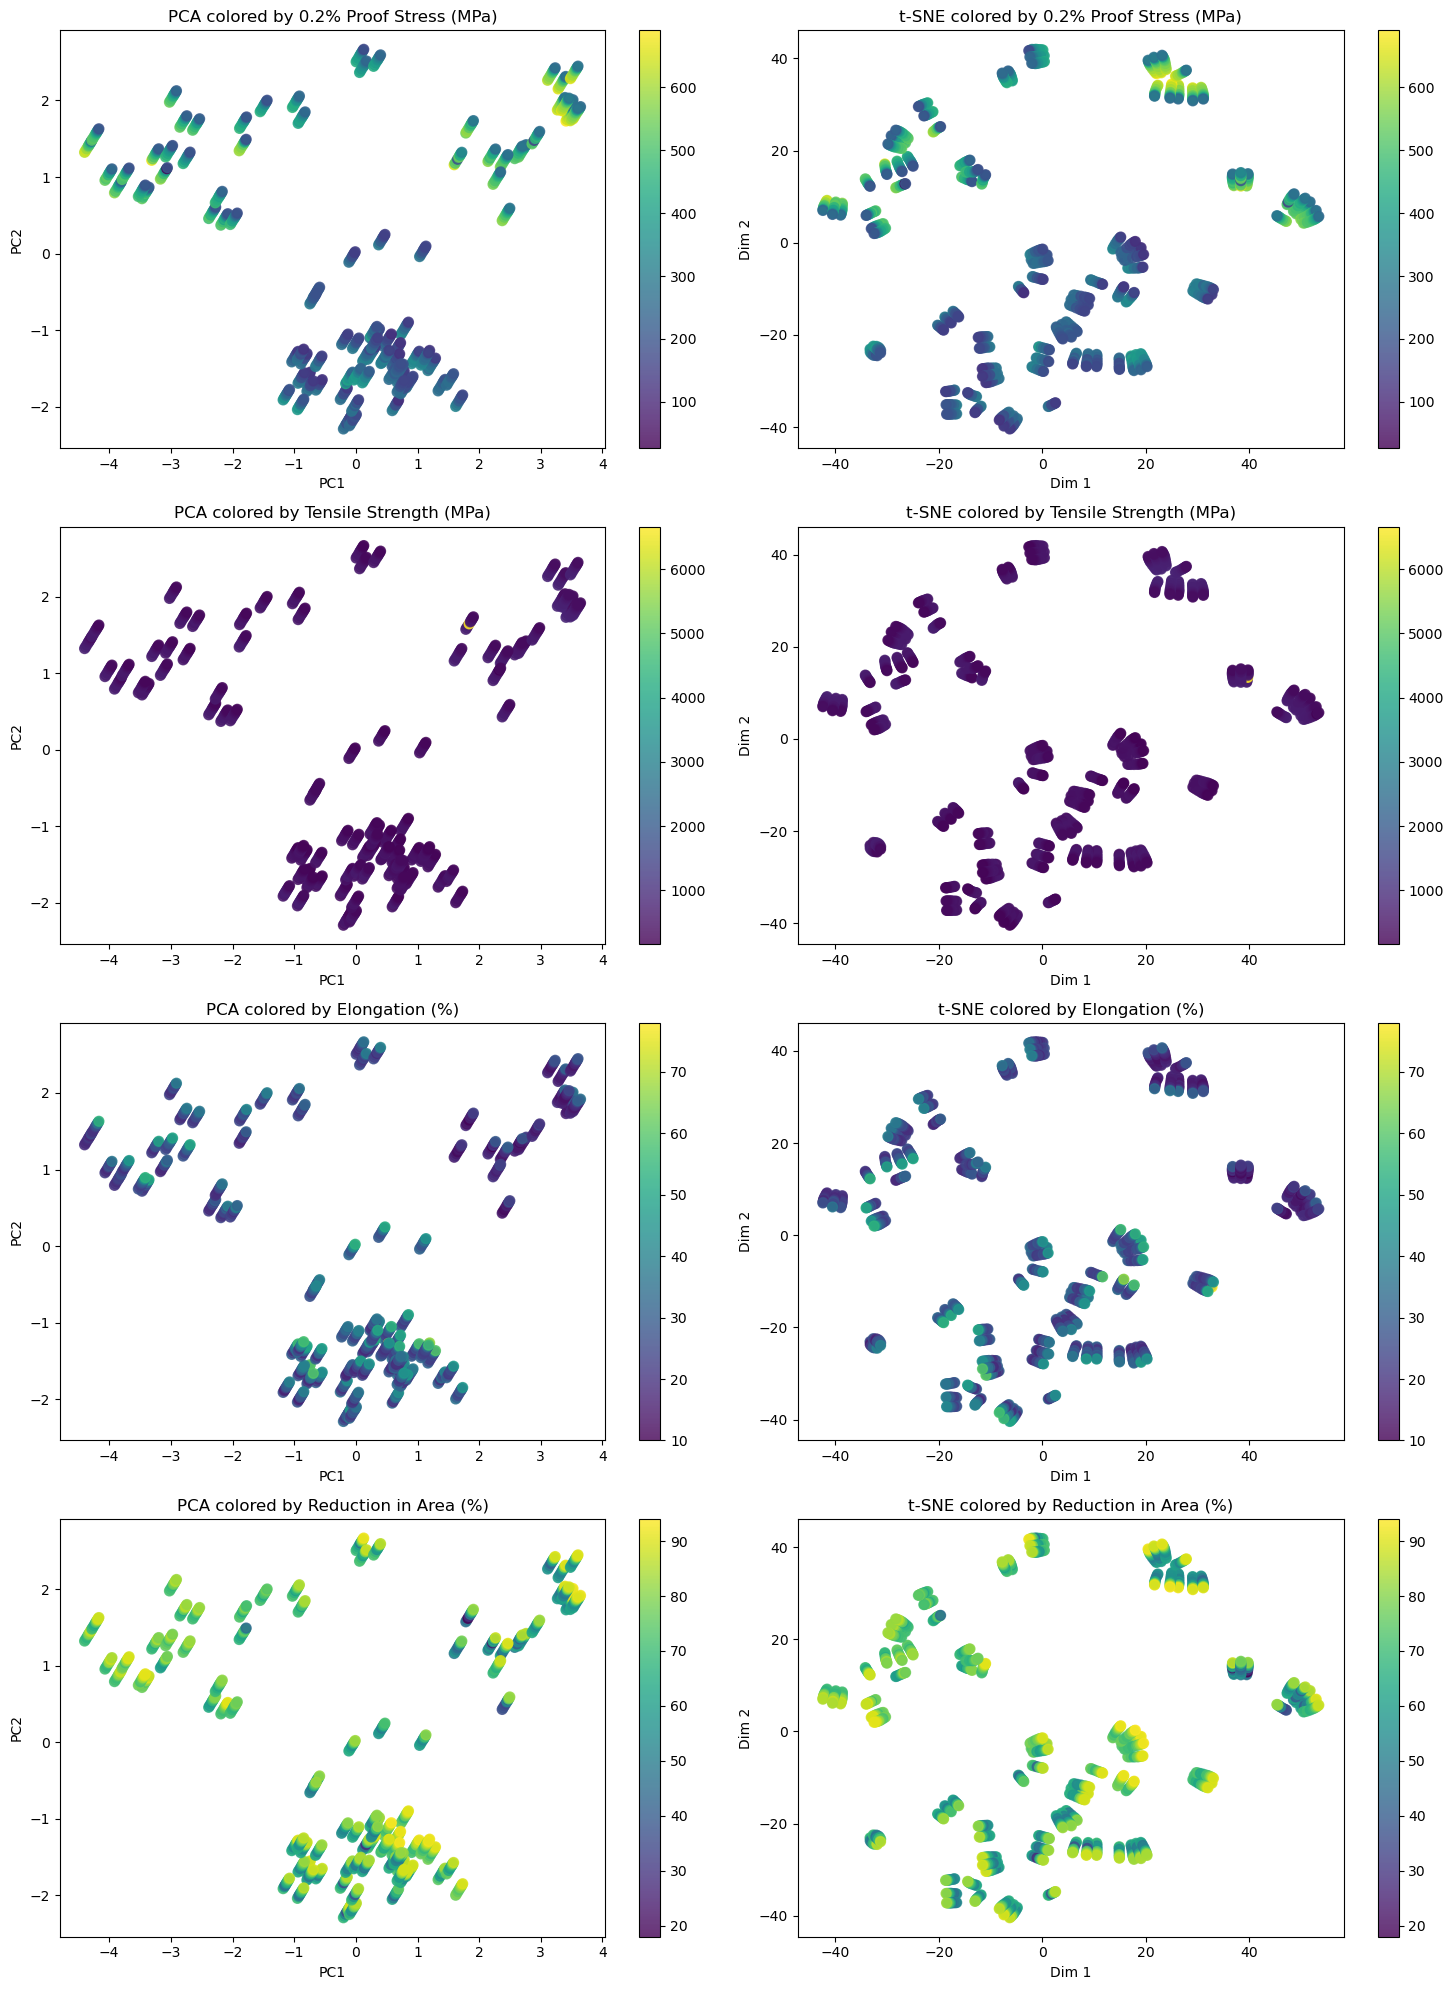

Визуализация для инженерных признаков:


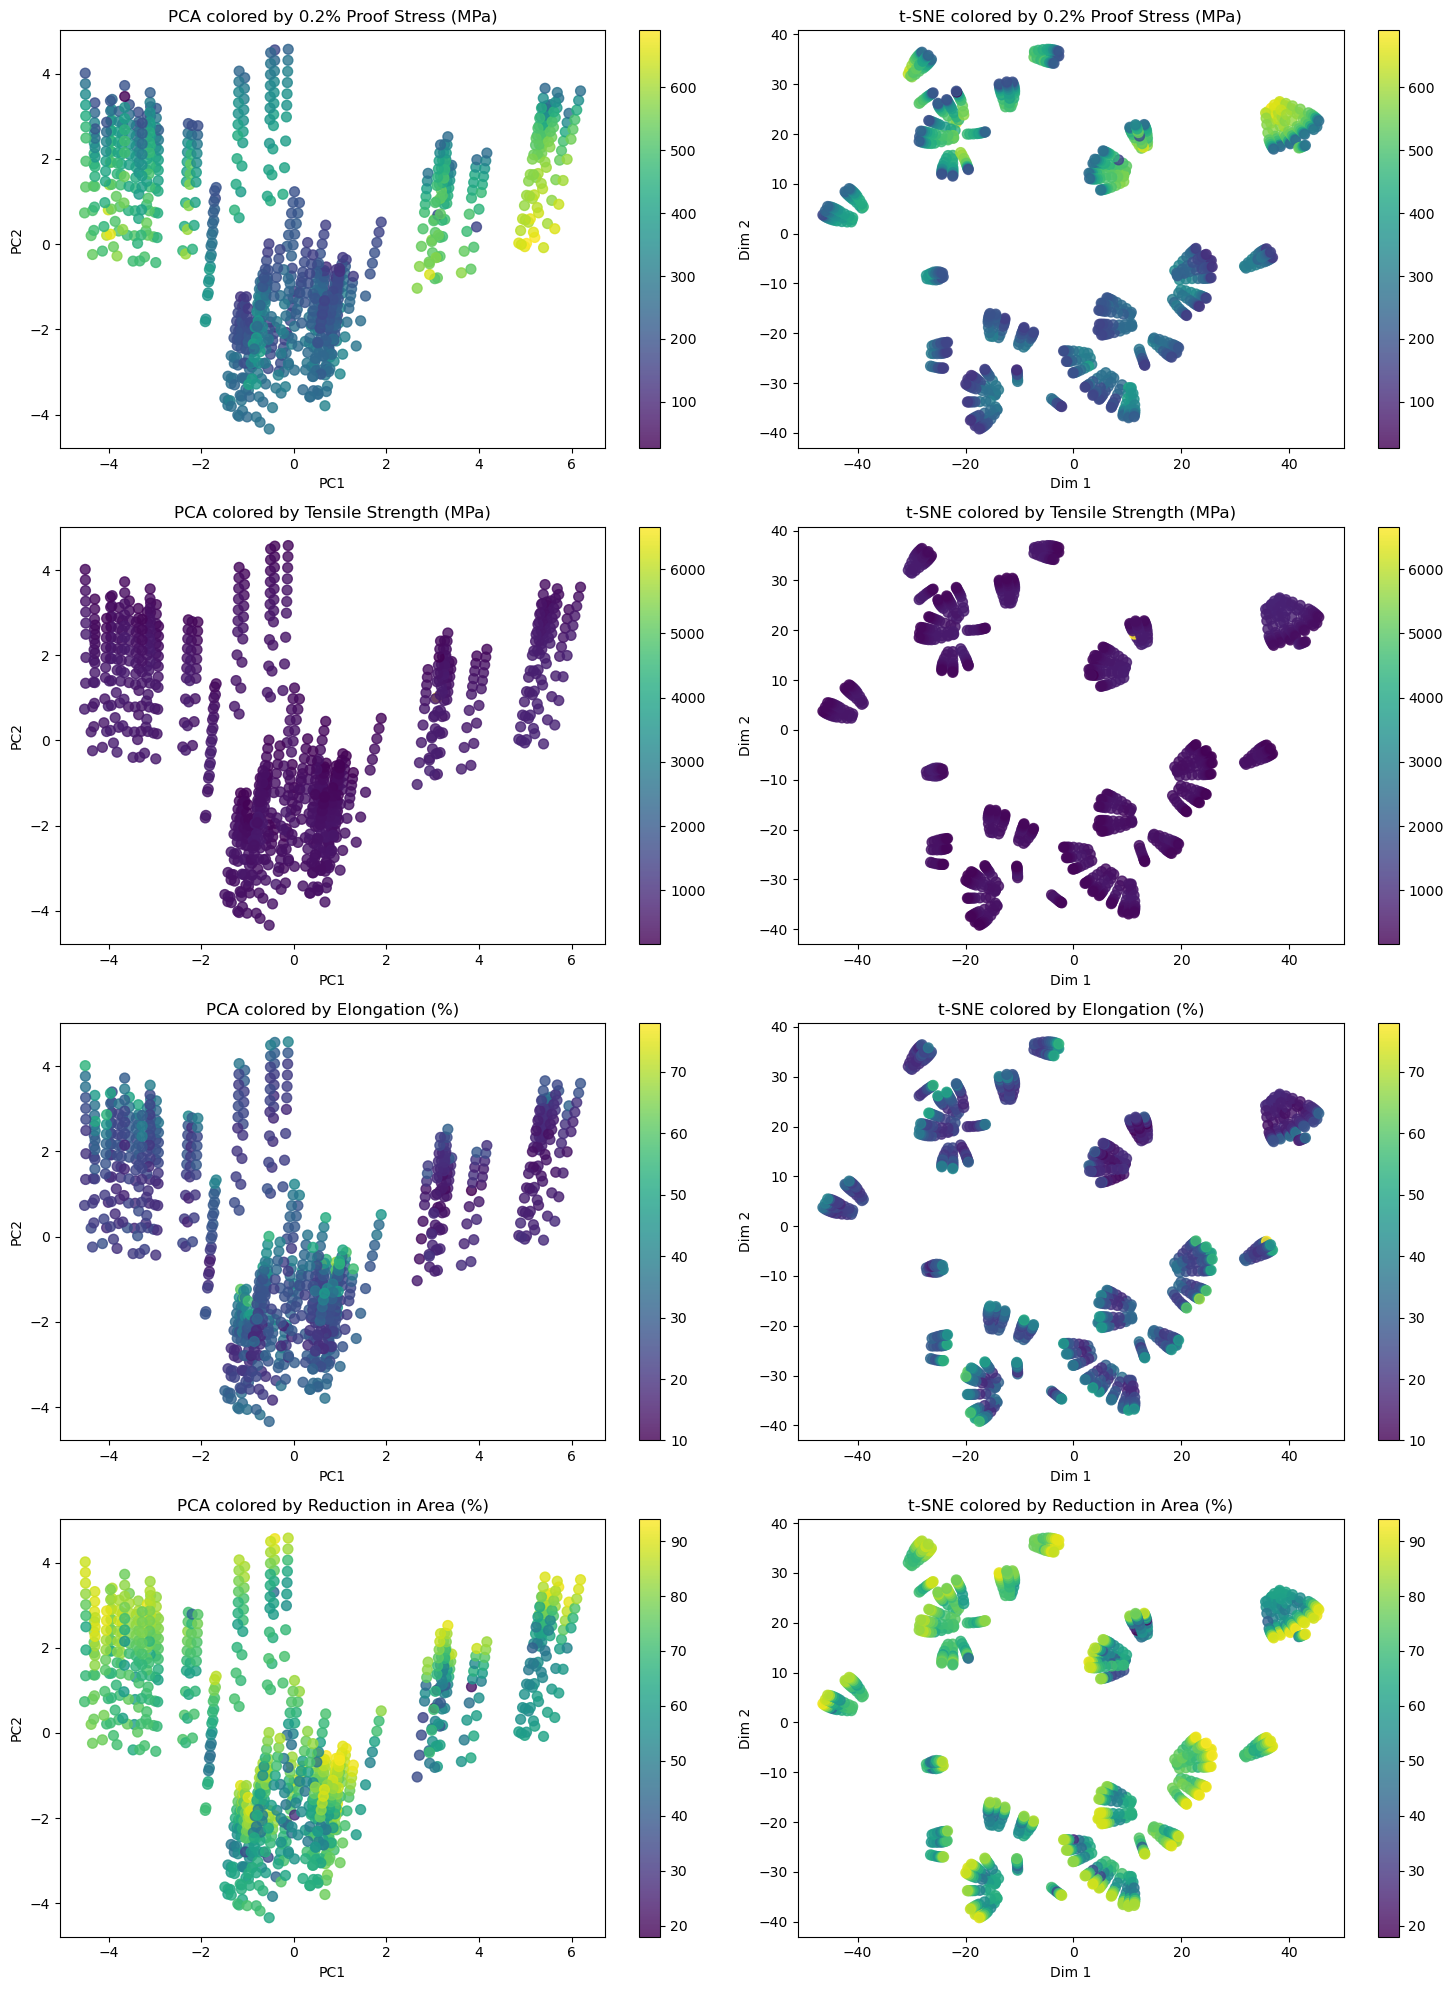

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

TARGETS = [
    "0.2% Proof Stress (MPa)",
    "Tensile Strength (MPa)",
    "Elongation (%)",
    "Reduction in Area (%)",
]
CATEGORICAL = ["Alloy code"]

NUMERIC = [c for c in X.columns if c not in CATEGORICAL]
NUMERIC_ENG = [c for c in X_eng.columns if c not in CATEGORICAL]


def create_visualizations(X_data, y_data, numeric_cols):
    preprocessor = ColumnTransformer(
        [
            ("num", StandardScaler(), numeric_cols),
            ("cat", OneHotEncoder(sparse_output=False), CATEGORICAL),
        ]
    )

    X_train_proc = preprocessor.fit_transform(X_data)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_train_proc)
    tsne = TSNE(n_components=2, random_state=42, max_iter=1000)
    X_tsne = tsne.fit_transform(X_train_proc)
    fig, axes = plt.subplots(len(TARGETS), 2, figsize=(15, 5 * len(TARGETS)))
    
    for i, target in enumerate(TARGETS):
        # PCA
        scatter1 = axes[i, 0].scatter(
            X_pca[:, 0], X_pca[:, 1], c=y_data[target], cmap="viridis", s=50, alpha=0.8
        )
        axes[i, 0].set_xlabel("PC1")
        axes[i, 0].set_ylabel("PC2")
        axes[i, 0].set_title(f"PCA colored by {target}")
        plt.colorbar(scatter1, ax=axes[i, 0])

        # t-SNE
        scatter2 = axes[i, 1].scatter(
            X_tsne[:, 0],
            X_tsne[:, 1],
            c=y_data[target],
            cmap="viridis",
            s=50,
            alpha=0.8,
        )
        axes[i, 1].set_xlabel("Dim 1")
        axes[i, 1].set_ylabel("Dim 2")
        axes[i, 1].set_title(f"t-SNE colored by {target}")
        plt.colorbar(scatter2, ax=axes[i, 1])

    plt.tight_layout()
    plt.show()


print("Визуализация для обычных признаков:")
create_visualizations(X, y, NUMERIC)

print("Визуализация для инженерных признаков:")
create_visualizations(X_eng, y, NUMERIC_ENG)